In [77]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate



In [78]:

def simuler(mv_test, # eV
            kvec,k_special=1,factor = 2.68,T_ini = 1000,H0 = 67.040):
    
    Res = np.zeros(len(kvec))
    Res1 = np.zeros(len(kvec))
    Res2 = np.zeros(len(kvec))
    Res4 = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    h = 0.6704
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # simulerings funktionerne

    def func_det_hele(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta      =  -  H(a) * a * theta    - (3/2) * H0*H0 * Omega_M * delta / a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]

    def func_del1(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        #nabla2phi = 
        d_theta   =  - (3/2) * H0*H0 * Omega_M * delta / a-  H(a) * theta * a
        return [d_delta,d_theta]

    
    t_gem = T_ini
    for k_ind,k in enumerate(kvec):
        T_ini = t_gem
        
        delta_class = pts[k_ind]["delta_cdm"]
        theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        if T_ini < tau_class[0]:
            print("Din T_ini er for lav.")
            print("T_ini sættes til lavest tau i class = %s ved k = %s" % (tau_class[0],k))
            T_ini = tau_class[0]
            #raise ValueError("T_ini=%s<tau[0]=%s" %(T_ini,tau_class[0]))
            
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
        theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
        delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
        theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
        
        
        τ_span = [T_ini,tau_class[-1]]

        y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]

        sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))

        τ_cdm_en = sol_en.t
        delta_cdm_en = sol_en.y[0]
        delta_nu_en = sol_en.y[2]

        Res[k_ind] = delta_nu_en[-1]
        Res4[k_ind] = delta_cdm_en[-1]
        # T-span1

        y01 = [delta_init,theta_init]

        sol_del1 = sc.solve_ivp(func_del1, t_span = τ_span, y0 = y01)

        τ_del1 = sol_del1.t

        delta_del1 = sol_del1.y[0]

        delta_cdm_interp = scipy.interpolate.interp1d(τ_del1,delta_del1)


        def func_del2(τ,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(τ)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp(τ)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
            return [d_delta,d_theta]

        y01_neutrino = [delta_neutrino_init,theta_neutrino_init]
        
        sol_neu1 = sc.solve_ivp(func_del2, t_span = τ_span, y0 = y01_neutrino,args=(k,mv,factor))
        
        Res1[k_ind] = sol_neu1.y[0][-1]
        Res2[k_ind] = delta_del1[-1]
        
        if k == k_special:
            plt.figure(3214)
            plt.loglog(tau_class,-delta_class,label="class cdm")
            plt.loglog(sol_neu1.t,-sol_neu1.y[0],label="alene neutrino")
            plt.loglog(τ_del1,-delta_del1,label="alene cdm")
            plt.loglog(τ_cdm_en,-delta_cdm_en,"-",label="cdm samlet")
            plt.loglog(τ_cdm_en,-delta_nu_en,"-.",label="neu samlet")
            plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
            plt.xlabel("tau")
            plt.legend()
            plt.title(r"$m_{\nu}=$%s eV k=%s cs-factor = %s" % (mv_test,k_special,factor))
    
    
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")

    # løs alt sammentidig

    # plot det hele
    plt.figure(1)

    plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"] ** 2* k ** (-3) * prim_interp(k) * h ** 3,"-.",label="neutrino")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"] ** 2 * k ** (-3) *  prim_interp(k) * h ** 3,"-.",label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res2** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"--",label="min hver for sig matter")
    plt.loglog(kvec,2*np.pi**2 * Res4** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"-.",label="samlet matter")
    plt.loglog(kvec,2*np.pi**2 * Res ** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,label="min samlet neu")
    plt.loglog(kvec,2*np.pi**2 * Res1** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"-.",label="min hver for sig neu")
    
    plt.xlabel("k")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini,factor))
    plt.legend()
    plt.xlim([kvec[0],kvec[-1]])
    
    
    return None



[-0.04233069 -0.06668102 -0.14825132 -0.38906302]
(delta_cdm1[0] / a[0] )=-85088.37080388512


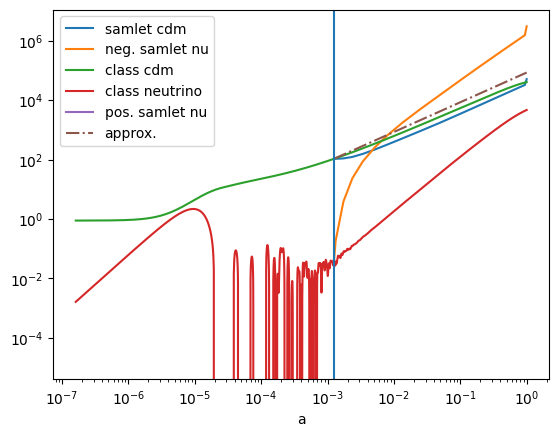

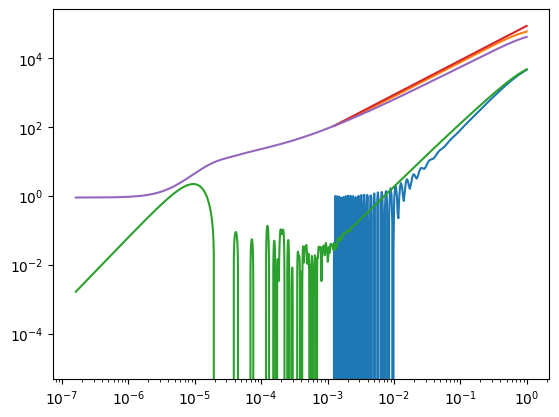

In [79]:
def f(mv_test,kvec,k_ind,H0=67,T_ini=1000):

    Res = np.zeros(len(kvec))
    Res1 = np.zeros(len(kvec))
    Res2 = np.zeros(len(kvec))
    Res4 = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    h = 0.6704
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren



    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # simulerings funktionerne

    def func_det_hele(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta      =  -  H(a) * a * theta    - (3/2) * H0*H0 * Omega_M * delta / a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]

    def func(a,y):
        delta = y[0]
        d_delta = y[1]
        #a = a_interp(τ)
        dd_delta = -3/2 * (1/a) * d_delta + 3/2 *(1/a)**2 * delta
        return [d_delta,dd_delta]
    
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]

    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    
    z = 3600
    z = 800
    #z = 3000
    a0 = 1/(1+z)
    T_ini = interp_tau_from_a(a0)
    a_span = [a0,1]
    
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
    theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
    delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
    theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

    #y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]
    y0 = [delta_init,-theta_init]
    #sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))
    sol = sc.solve_ivp(func,t_span=a_span,y0 = y0)
    a = sol.t
    delta = sol.y[0]
    delta_interp = scipy.interpolate.interp1d(a,delta)
    #τ_cdm_en = sol_en.t
    #delta_cdm_en = sol_en.y[0]
    #delta_nu_en = sol_en.y[2]

    #plt.loglog(tau_class,-delta_class)
    #plt.loglog(a_class,-delta_class)
    ##print(delta)
    #plt.loglog(a,-delta)
    #plt.axvline(a0)
    #plt.title("delta(a) test k = %s mv= %s eV"%(kvec[k_ind],mv_test))
    #plt.xlabel("a")
    #plt.figure(134)
    
    def func1(a,y,n,mv,factor,k,A):
        delta = y[0]
        theta = y[1]
        #a = a_interp(τ)
        #A = delta_class[0] / (a**(n))
        delta_cdm = A * a** n
        d_delta = - theta
        d_theta =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
        return [d_delta,d_theta]
    
    def F(a,y,k,mv,factor,A):
        delta_cdm = y[0]
        d_delta_cdm = y[1]
        delta_nu = y[2]
        d_delta_nu = y[3]
        d2_delta_cdm = - 3/2 * 1/a * d_delta_cdm + 3/2 * 1/a**2 *delta_cdm
        d2_delta_nu = + (k**2 * cs(a,mv,factor)**2)/(a*Omega_M) * delta_nu+ 1/2 * 1/a * d_delta_nu + 3/2 *1/a * A# * a#delta_cdm 
        return [d_delta_cdm,d2_delta_cdm,d_delta_nu,d2_delta_nu]
    
    
    def F1(a,y,k,mv,factor,A):
        delta_cdm = y[0]
        d_delta_cdm = y[1]
        delta_nu = y[2]
        d_delta_nu = y[3]
        d2_delta_cdm = - 3/2 * 1/a * d_delta_cdm + 3/2 * 1/a**2 *delta_cdm
        d2_delta_nu = + (k**2 * cs(a,mv,factor)**2)/(a*Omega_M) * delta_nu+ 1/2 * 1/a * d_delta_nu + 3/2 * delta_cdm/(a**2)  
        return [d_delta_cdm,d2_delta_cdm,d_delta_nu,d2_delta_nu]
        
        
    
    #plt.loglog(a_class,-delta_class,label="class cdm")
    #print(delta)
    n= 0.9
    A = delta[0] / (a[0]**(n))
    #plt.loglog(a,-A * a** n,"-.",label="a^%s"%n)
    n= 1
    A = delta[0] / (a[0]**(n))
    #plt.loglog(a,-A * a** n,"-.",label="a^%s"%n)
    n= 0.85
    A = delta[0] / (a[0]**(n))
    #plt.loglog(a,-A * a** n,"-.",label="a^%s"%n)
    
    y0 = [delta_neutrino_init,-theta_neutrino_init]
    #sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))
    
    
    n = 1
    k = kvec[k_ind]
    cs_factor = 2.67
    A =  delta_init / (a_span[0]**(n))
    sol = sc.solve_ivp(func1,t_span=a_span,y0 = y0,args=(n,mv,cs_factor,k,A))
    #,t_eval=np.logspace(np.log10(a_span[0]),0,50))
    a = sol.t
    delta = sol.y[0]
    print(delta)
    #plt.axvline(a0)
    #plt.title("For the meme")
    #
    #plt.loglog(a_class,-delta_neutrino_class,label="class neutrino")
    #plt.loglog(a,delta,label="min neu - positive")
    #plt.loglog(a,-delta,label="min neu - negative")
    #plt.xlabel("a")
    #plt.legend(loc="upper left")
    
    y1 = [delta_init,-theta_init,delta_neutrino_init,-theta_neutrino_init]
    A =  delta[0] / (a_span[0]**(1))
    sol = sc.solve_ivp(F,t_span=a_span,y0=y1,args=(k,mv,cs_factor,A))
    
    a = sol.t
    delta_cdm = sol.y[0]
    delta_nu = sol.y[2]
    
    #plt.figure(2132)
    #
    #
    #plt.loglog(a,-delta_cdm,label="samlet cdm")
    #plt.loglog(a,-delta_nu,label="neg. samlet nu")
    #plt.loglog(a_class,-delta_class,label="class cdm")
    #plt.loglog(a_class,-delta_neutrino_class,label="class neutrino")
    #plt.loglog(a,delta_nu,label="pos. samlet nu")
    #A = delta_cdm[0] / a[0]
    #plt.loglog(a,-A*a,"-.",label="approx.")
    #plt.xlabel("a")
    #plt.axvline(a0)
    #plt.legend(loc="upper left")
    A =  delta[0] / (a_span[0]**(1))
    sol1 = sc.solve_ivp(F1,t_span=a_span,y0=y1,args=(k,mv,cs_factor,A))
    
    a = sol.t
    delta_cdm = sol1.y[0]
    delta_nu = sol1.y[2]
    plt.figure(11323223)
    plt.loglog(a,-delta_cdm,label="samlet cdm")
    plt.loglog(a,-delta_nu,label="neg. samlet nu")
    plt.loglog(a_class,-delta_class,label="class cdm")
    plt.loglog(a_class,-delta_neutrino_class,label="class neutrino")
    plt.loglog(a,delta_nu,label="pos. samlet nu")
    A = delta_cdm[0] / a[0]
    plt.loglog(a,-A*a,"-.",label="approx.")
    plt.xlabel("a")
    plt.axvline(a0)
    plt.legend(loc="upper left")
    
    cs_factor = 2.67
    beta = ((cs_factor*k*T0)/(H0*mv))**2 / Omega_M
    delta0 = delta_init

    def f(a,c1):
        return np.exp(1/3 * (beta * (1/a**2 -1) + (a**2 -1))) * (c1 - delta0/(3*a0) * (np.exp(1-beta/2) - np.exp(a**2 / 2 - beta/(2*a))*(1/a) * np.exp(-beta * np.log(a))))

    a = a_class
    
    #np.logspace(a0,0,30)
    #plt.figure(1212222)
    #plt.loglog(a_class,-delta_neutrino_class)
    #plt.loglog(a,-f(a,0))
    ##plt.loglog(a,-f(a,0))
    #plt.figure(12312122)
    #plt.loglog(a,-f(a,0))
    #plt.loglog(a,f(a,0))
    
    k = kvec[k_ind]
    delta_cdm1 = sol1.y[0]
    def func1(a,y,mv,cs_factor,k):
        delta = y[0]
        theta = y[1]
        delta_cdm = y[2]
        
        theta_cdm = y[3]
        
        d_delta_cdm = 1/(a**2 * H(a)) * (-theta_cdm)
        d_theta_cdm = 1/(a**2 * H(a))*(-a*H(a)*theta_cdm - 3/2 * H0**2 * Omega_M/a * delta_cdm)
        d_delta = -theta/(a**2 * H(a))
        d_theta = 1/(a**2 * H(a)) * (-a*H(a)*theta-3/2 *H0**2* Omega_M /a * delta_cdm + k**2 * cs(a,mv,cs_factor)**2 * delta)
        return [d_delta,d_theta,d_delta_cdm,d_theta_cdm]
    
    
    y0 =[delta_neutrino_init,theta_neutrino_init,delta_init,theta_init]
    #print(a_span)
    sol = scipy.integrate.solve_ivp(func1,a_span,y0,args=(mv,cs_factor,k))
    plt.figure(333333)
    plt.loglog(sol.t,-sol.y[0])
    plt.loglog(sol.t,-sol.y[2])
    plt.loglog(a_class,-delta_neutrino_class)
    a = sol.t
    #print(delta_cdm1)
    delta  = a * (delta_cdm1[0] / a[0] )
    print(f"{(delta_cdm1[0] / a[0] )=}")
    #print(delta)
    plt.loglog(a,-delta)
    plt.loglog(a_class,-delta_class)
    
    return None

kvec = [1e-2,1e-1,1,1e1]
mv = 1
f(mv,kvec = kvec,k_ind=2)


delta_neutrino_init=array(-0.19077922)


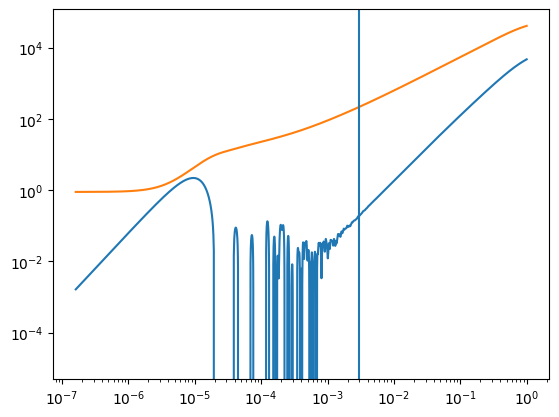

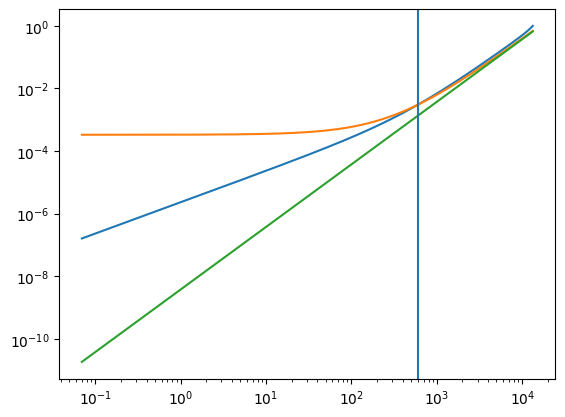

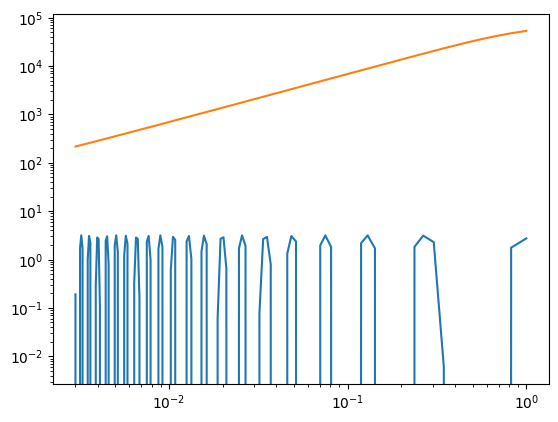

In [80]:
mv_test = 1
kvec = [1]
k_ind = 0
H0=67
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
# 
h = 0.6704
cs_factor = 2.67
cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
H0 /= (3*1e5) # i 1/Mpc
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
# cs front faktoren



    # udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
a_class = pts[k_ind]["a"]

interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)

z = 3600
z = 800
z = 332
#z = 3000
a0 = 1/(1+z)
T_ini = interp_tau_from_a(a0)
a_span = [a0,1]

delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
print(f"{delta_neutrino_init=}")
#y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]
y0 = [delta_init,-theta_init]
k=1
def func1(a,y,mv,cs_factor,k):
    delta = y[0]
    theta = y[1]
    delta_cdm = y[2]

    theta_cdm = y[3]

    d_delta_cdm = 1/(a**2 * H(a)) * (-theta_cdm)
    d_theta_cdm = 1/(a**2 * H(a))*(-a*H(a)*theta_cdm - 3/2 * H0**2 * Omega_M/a * delta_cdm)
    d_delta = -theta/(a**2 * H(a))
    d_theta = 1/(a**2 * H(a)) * (-a*H(a)*theta + k**2 * cs(a,mv,cs_factor)**2 * delta)#-3/2 *H0**2* Omega_M /a * delta_cdm
    return [d_delta,d_theta,d_delta_cdm,d_theta_cdm]


y0 =[delta_neutrino_init,theta_neutrino_init,delta_init,theta_init]
#print(a_span)
sol = scipy.integrate.solve_ivp(func1,a_span,y0,args=(mv,cs_factor,k))
plt.figure(333333)

def paste():
    plt.loglog(sol.t,-sol.y[0])
    plt.loglog(sol.t,-sol.y[2])
    return None
plt.loglog(a_class,-delta_neutrino_class)

plt.loglog(a_class,-delta_class)
plt.axvline(a0)
a = sol.t
#print(delta_cdm1)
plt.figure(8888)
plt.loglog(tau_class,a_class)
plt.loglog(tau_class,(1/2 * H0 * np.sqrt(Omega_M) * (tau_class-T_ini)+np.sqrt(a0))**2)
plt.loglog(tau_class,1/4 * H0**2 * Omega_M * tau_class**2)
plt.axvline(T_ini)
plt.figure(213)
paste()

Skærmbilled fram wolframaplha
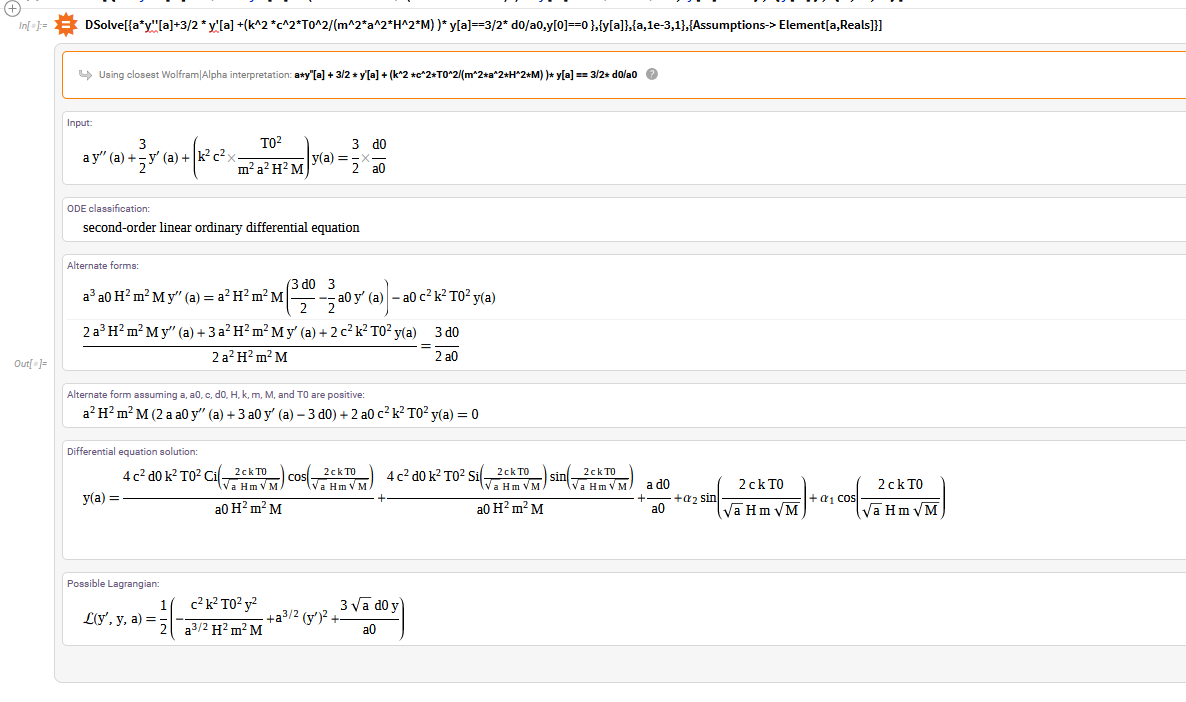


Den homogene løsning

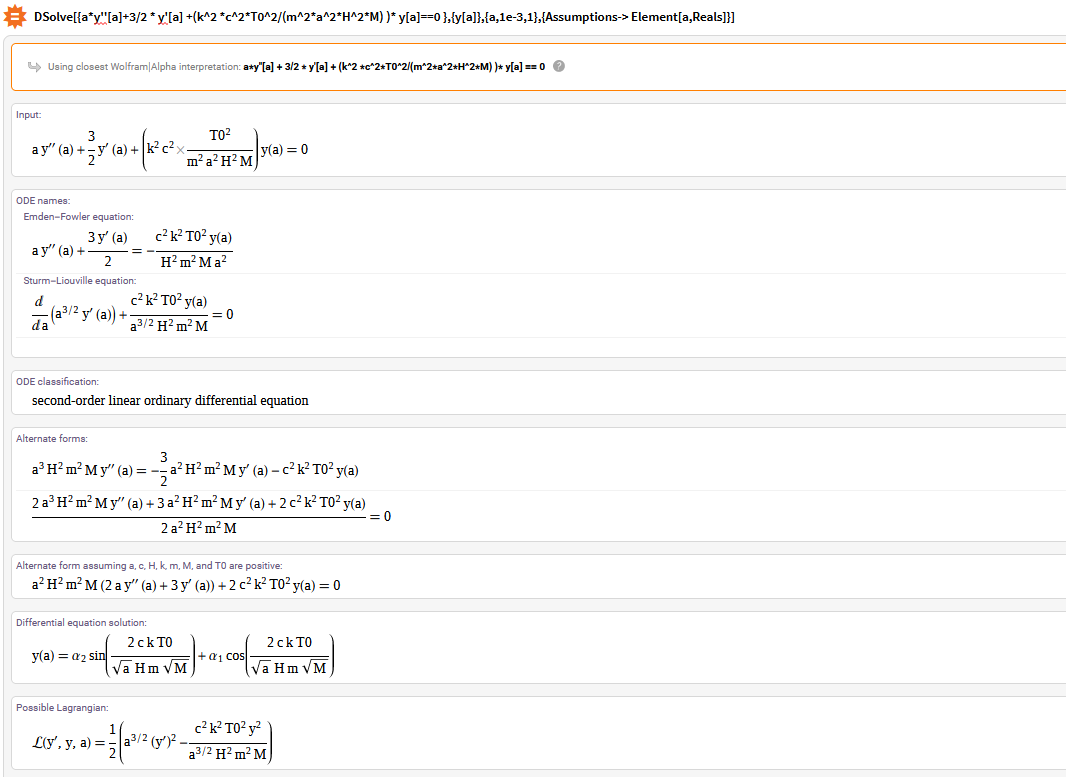

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
[{'tau [Mpc]': array([7.00092858e-02, 7.00092933e-02, 7.00093007e-02, ...,
       1.28443570e+04, 1.31205539e+04, 1.33016618e+04]), 'a': array([1.60995538e-07, 1.60995555e-07, 1.60995572e-07, ...,
       9.04707869e-01, 9.60664668e-01, 1.00000000e+00]), 'delta_g': array([-1.18286727, -1.18286727, -1.18286727, ..., -0.00446644,
       -0.0043603 , -0.00428574]), 'theta_g': array([ 2.06620618e-02,  2.06620640e-02,  2.06620662e-02, ...,
       -2.78467258e-08, -2.59634465e-08, -2.47413654e-08]), 'shear_g': array([4.33748342e-10, 4.33748480e-10, 4.33748618e-10, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'pol0_g': array([1.08437086e-09, 1.08437120e-09, 1

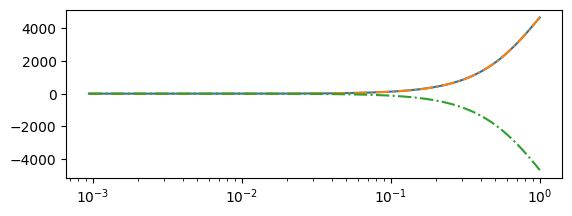

In [107]:
cs_factor = 2.67
import scipy.special as special
mv_test = 1
kvec = [1]
k_ind = 0
k = kvec[k_ind]
H0=67
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
# 
h = 0.6704
cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
H0 /= (3*1e5) # i 1/Mpc
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
print(bg.keys())
print(pts)
print(pts[0].keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
# cs front faktoren



    # udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
a_class = pts[k_ind]["a"]

interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)

z = 3600
z = 800
#z = 3000
a0 = 1/(1+z)
T_ini = interp_tau_from_a(a0)
a_span = [a0,1]

delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)
neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)
a_interp = scipy.interpolate.interp1d(tau_class,a_class)
tau = np.linspace(T_ini,1,100)
a_neu = a_interp(tau)
neutrino = neu_interp(a_neu)
#print(a_neu,neutrino)
#y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]
#y0 = [delta_init,-theta_init]
beta = ((cs_factor*k*T0)/(H0*mv))**2 / Omega_M
delta0 = delta_init(T_ini)
#fig = plt.figure()
#ax = fig.add_subplot(2, 1, 1)

#line, = ax.plot(a_class,delta_neutrino_class, color='blue')

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_data_i(1e-7,1e-2)
#plt.xlim([1e-2,1])
#plt.logx()
#paste()
def func(x, a, b, c):
     return a * np.exp(-b * x) + c
fig2 = plt.figure(324)
#plt.plot(a_neu,neutrino)
print(len(a_class))

ax1 = fig2.add_subplot(2, 1, 1)



#ax1.set_xscale('log')

"""popt, pcov = optimize.curve_fit(func, a_class[4000:],delta_neutrino_class[4000:])
plt.plot(a_class[4000:],func(a_class[4000:],*popt))
print(popt)"""

N = 3000
x,y = a_class[N:],delta_neutrino_class[N:]
#plt.xlim([1e-2,1])

n = 4
z = np.polyfit(x,y,n)
print(z)
p = np.poly1d(z)
plt.plot(x,-y)
plt.plot(x,-p(x),"-.")
plt.plot(x,p(x),"-.")
Error = np.mean(np.power((y-p(x)),2))
print(Error)
plt.xscale('log')
#plt.yscale('log')

1.2834869932681512
-1159.5720057459343


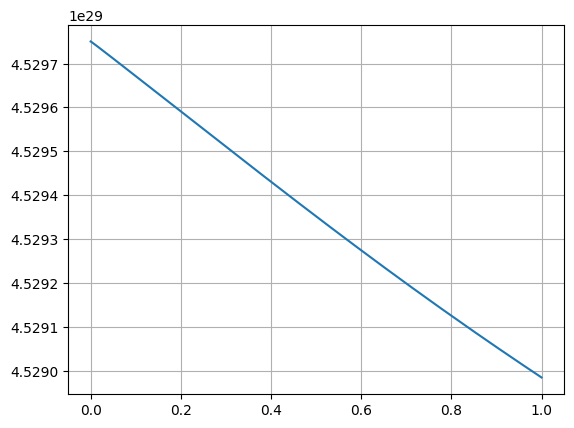

In [132]:
### from scipy.special import sinc, sici

def g(a,c1,c2):
    val = 2*cs_factor*k*T0/(np.sqrt(a)*H0*mv*np.sqrt(Omega_M))
    si,ci = special.sici(val)
    return 4 * cs_factor**2 * delta0*k**2*T0/(a0*H0**2 * mv**2 * Omega_M) *(ci*np.cos(val)+si*np.sin(val)) + a *delta0/a0 + c1 * np.sin(val) + c2*np.cos(val)


print(np.sum(sici(1)))
print((-1e3-np.cos(2*k*cs(1,mv,cs_factor)/(H0*np.sqrt(Omega_M))))/np.sin(2*k*cs(1,mv,cs_factor)/(H0*np.sqrt(Omega_M))))


def g(t,c1=0,c2=0):
    c =  cs(1,mv,cs_factor) # alle factorerne i cs(a)
    
    """return (c*delta0 * H0**2 * k * Omega_M-2*c**3 *delta0*k**3 * np.cos(((-2+126*np.sqrt(a))*c*k)/(np.sqrt(a)*H0*np.sqrt(Omega_M)) )*sinc(63*c*k/(H0*np.sqrt(Omega_M))) 
           +c**3 * delta0*k**3 * np.cos(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M))) * 
            ( -4*sici(63*c*k/(H0*np.sqrt(Omega_M)))[1]+4*sici(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M)))[1]+2*sinc(63*c*k/(H0*np.sqrt(Omega_M))))
           +c**3 * delta0*k**3 * np.sin(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M))) * 
            ( -4*sici(63*c*k/(H0*np.sqrt(Omega_M)))[0]+4*sici(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M)))[0])) /(a0*c*H0**2 * k *Omega_M)"""
    d0 = delta0#/a0
    #d0 = 1
    #c=10**0.5
    return (d0*(-560+840 * c**2 * k**2 * t**(2/3) - 378 * c**4 * k**4 * t**(4/3)
                +81*c**6*k**6*t**2) +(27*c**7*k**7*(2*c1*np.cos(3*c*k*t**(1/3))
                +c2*np.sin(3*c*k*t**(1/3))))/(t**(1/3))) / (81 * c**8*k**8 )

#paste()



def g(a,tau,c1=1,c2=1):
    c =  cs(1,mv,cs_factor) # alle factorerne i cs(a)
    
    """return (c*delta0 * H0**2 * k * Omega_M-2*c**3 *delta0*k**3 * np.cos(((-2+126*np.sqrt(a))*c*k)/(np.sqrt(a)*H0*np.sqrt(Omega_M)) )*sinc(63*c*k/(H0*np.sqrt(Omega_M))) 
           +c**3 * delta0*k**3 * np.cos(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M))) * 
            ( -4*sici(63*c*k/(H0*np.sqrt(Omega_M)))[1]+4*sici(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M)))[1]+2*sinc(63*c*k/(H0*np.sqrt(Omega_M))))
           +c**3 * delta0*k**3 * np.sin(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M))) * 
            ( -4*sici(63*c*k/(H0*np.sqrt(Omega_M)))[0]+4*sici(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M)))[0])) /(a0*c*H0**2 * k *Omega_M)"""
    d0 = delta0#/a0
    #d0 = 1
    #c=10**0.5
    t = a*tau
    return (d0*(-560+840 * c**2 * k**2 * t**(2/3) - 378 * c**4 * k**4 * t**(4/3)
                +81*c**6*k**6*t**2) +(27*c**7*k**7*(2*c1*np.cos(3*c*k*t**(1/3))
                +c2*np.sin(3*c*k*t**(1/3))))/(t**(1/3))) / (81 * c**8*k**8 )

#paste()


t = np.linspace(0.1,5,100)
t = bg["proper time [Gyr]"]*365*24*60*60
plt.plot(a_class,g(a_class,tau_class))

#plt.loglog(a_class,-delta_neutrino_class)
#a = np.logspace(np.log10(a0),0,30)
#plt.loglog(a_class,delta_neutrino_class)
#plt.loglog(a,-g(a))#,-1158,1))
#plt.loglog(a,-f(a,0))
plt.grid()


![Sk%C3%A6rmbillede%202023-03-06%20083719.png](attachment:Sk%C3%A6rmbillede%202023-03-06%20083719.png)
